<a href="https://colab.research.google.com/github/chigvintseva/UniProject-simulation-techniques/blob/main/main_ST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data generation**

## Libraries importing

In [1284]:
import numpy as np
import pandas as pd
import simpy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## Initial data generation steps

### 1. Set random seed for reproducibility

In [1285]:
# to ensure the reproducable synthetic data generation
np.random.seed(42)

### 2. Generate patient arrival times using poisson process

In [1286]:
arrival_rate_per_hour = 30
simulation_duration_hours = 24

#total patient count
num_patients = np.random.poisson(lam=arrival_rate_per_hour * simulation_duration_hours)

In [1287]:
#inter-arrival times (in hours) from exponential distribution
inter_arrival_times = np.random.exponential(scale=1/arrival_rate_per_hour, size=num_patients)

In [1288]:
#cumulative arrival times
arrival_times = np.cumsum(inter_arrival_times)

## Arrivals example for data verfification & triage categories assigning:

In [1289]:
print("Sample of Patient Arrival Times:")
for i, arrival in enumerate(arrival_times[:5], start=1):
    hours = int(arrival)
    minutes = int((arrival - hours) * 60)
    print(f"  Patient {i}: {hours} hours and {minutes} minutes after simulation start")

Sample of Patient Arrival Times:
  Patient 1: 0 hours and 2 minutes after simulation start
  Patient 2: 0 hours and 4 minutes after simulation start
  Patient 3: 0 hours and 4 minutes after simulation start
  Patient 4: 0 hours and 5 minutes after simulation start
  Patient 5: 0 hours and 5 minutes after simulation start


3. Assign Triage Categories with Weighted Sampling

In [1290]:
# triage levels and their empirical probabilities
triage_levels = [1, 2, 3, 4, 5]
triage_probabilities = [0.1, 0.2, 0.3, 0.25, 0.15]

In [1291]:
#random assign triage categories to each patient
assigned_triage = np.random.choice(triage_levels, size=num_patients, p=triage_probabilities)

In [1292]:
# Display normalized frequency distribution
print("Normalized triage distribution:")
print(pd.Series(assigned_triage).value_counts(normalize=True).sort_index())

Normalized triage distribution:
1    0.100000
2    0.214085
3    0.274648
4    0.247887
5    0.163380
Name: proportion, dtype: float64


## Visualisation of the triage distribution

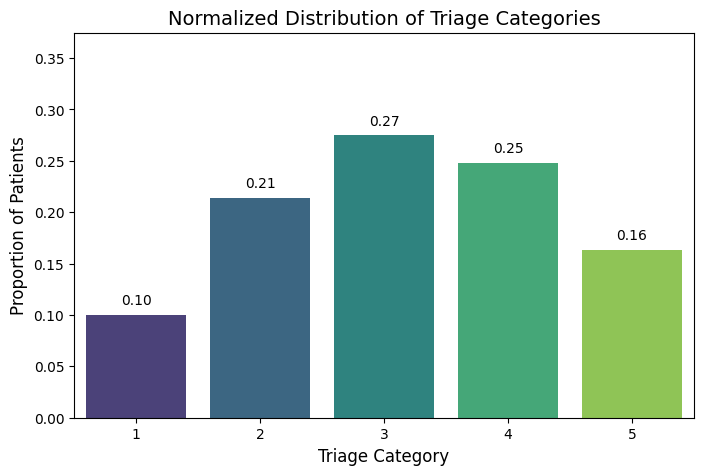

In [1293]:
triage_counts = pd.Series(assigned_triage).value_counts(normalize=True).sort_index()
triage_levels = triage_counts.index.astype(str)
frequencies = triage_counts.values

plt.figure(figsize=(8, 5))
sns.barplot(x=triage_levels, y=frequencies, hue=triage_levels, palette="viridis", dodge=False, legend=False)

plt.xlabel('Triage Category', fontsize=12)
plt.ylabel('Proportion of Patients', fontsize=12)
plt.title('Normalized Distribution of Triage Categories', fontsize=14)

#Show proportion values on top of bars
for i, freq in enumerate(frequencies):
    plt.text(i, freq + 0.01, f'{freq:.2f}', ha='center', fontsize=10)
plt.ylim(0, max(frequencies) + 0.1)
plt.show()

## Diagnostic testing requirements with Bernoulli Trials

In [1294]:
#probability of requiring diagn. testing - 30% is typical for clinical studies
diagnostic_probability = 0.3

In [1295]:
# binary diagnostic requirement flags to patients
requires_diagnostics = np.random.binomial(n=1, p=diagnostic_probability, size=num_patients)

In [1296]:
print(f"Percentage of patients requiring diagnostics: {requires_diagnostics.mean() * 100:.2f}%")

Percentage of patients requiring diagnostics: 29.44%


## **5. Sample process durations using Triangular Distributions**

to avoid zero to negative values & return array of samples.

parameters:

*  minimum: minimum value of distribution
*  mode: most likely (peak) value
*  maximum: maximum value
*  sample_size: number of samples to generate

In [1297]:
def triangular_sample(minimum, mode, maximum, sample_size):
  samples = np.random.triangular(left=minimum, mode=mode, right=maximum, size=sample_size)
  return np.clip(samples, a_min=0.1, a_max=None)  # ensures positive durations

In [1298]:
# sample process durations in minutes for each patient

triage_times = triangular_sample(5, 10, 15, num_patients)
registration_times = triangular_sample(3, 7, 12, num_patients)
consultation_times = triangular_sample(15, 25, 40, num_patients)
diagnostic_times = triangular_sample(20, 30, 45, num_patients)
treatment_times = triangular_sample(10, 20, 35, num_patients)

In [1299]:
# setting diagnostics to 0 for pations not requiring it
diagnostic_times *= requires_diagnostics

In [1300]:
print("Sample of Consultation Times (minutes):")
for i, time in enumerate(consultation_times[:5], start=1):
    print(f"  Patient {i}: {time:.2f} minutes")

Sample of Consultation Times (minutes):
  Patient 1: 27.46 minutes
  Patient 2: 26.38 minutes
  Patient 3: 21.00 minutes
  Patient 4: 28.13 minutes
  Patient 5: 23.27 minutes


## 6. Gather generated variables into chronologically ordered dataset for further simulation (both control and manipulated scenarios)

In [1301]:
ed_patient_data = pd.DataFrame({
    'arrival_time_hr': arrival_times,   #hours since simulation start
    'triage_category': assigned_triage,  #triage levels 1–5
    'requires_diagnostics': requires_diagnostics,   #booleans
    'triage_time_min': triage_times,  #continuous var-s, process durations in minutes
    'registration_time_min': registration_times,
    'consultation_time_min': consultation_times,
    'diagnostic_time_min': diagnostic_times,
    'treatment_time_min': treatment_times
})

In [1302]:
#sort dataset by arrival time to ensure the correct event sequencing
ed_patient_data.sort_values('arrival_time_hr', inplace=True)
ed_patient_data.reset_index(drop=True, inplace=True)

In [1303]:
#sort and reset index
ed_patient_data.sort_values('arrival_time_hr', inplace=True)
ed_patient_data.reset_index(drop=True, inplace=True)
# verify with the previous one - compare
print(ed_patient_data.head())

   arrival_time_hr  triage_category  requires_diagnostics  triage_time_min  \
0         0.043892                3                     0        10.308282   
1         0.074323                3                     0        10.138928   
2         0.079977                3                     1        11.254026   
3         0.085630                5                     1        12.657545   
4         0.087625                4                     0         6.992569   

   registration_time_min  consultation_time_min  diagnostic_time_min  \
0              10.084064              27.460549             0.000000   
1              10.513994              26.382577             0.000000   
2               7.637720              21.001641            33.703268   
3               6.585577              28.125634            30.534957   
4               8.908028              23.271040             0.000000   

   treatment_time_min  
0           21.654345  
1           24.522863  
2           17.939976  
3 

In [1304]:
print("Sample of Generated Patient Data (first 5 rows):\n")

# Select relevant columns for display
sample = ed_patient_data.head()

# Rename columns with descriptive headers for clarity
sample = sample.rename(columns={
    'arrival_time_hr': 'Arrival',
    'triage_category': 'TriageCat.',
    'requires_diagnostics': 'Needs Diagn.?',
    'triage_time_min': 'Triage(min)',
    'registration_time_min': 'Registr.(min)',
    'consultation_time_min': 'Consult.(min)',
    'diagnostic_time_min': 'Diagnostic(min)',
    'treatment_time_min': 'Treatment(min)'
})

print(sample.to_string(index=False))

Sample of Generated Patient Data (first 5 rows):

 Arrival  TriageCat.  Needs Diagn.?  Triage(min)  Registr.(min)  Consult.(min)  Diagnostic(min)  Treatment(min)
0.043892           3              0    10.308282      10.084064      27.460549         0.000000       21.654345
0.074323           3              0    10.138928      10.513994      26.382577         0.000000       24.522863
0.079977           3              1    11.254026       7.637720      21.001641        33.703268       17.939976
0.085630           5              1    12.657545       6.585577      28.125634        30.534957       20.595918
0.087625           4              0     6.992569       8.908028      23.271040         0.000000       15.555400


## Visuals of the dataset by triage category

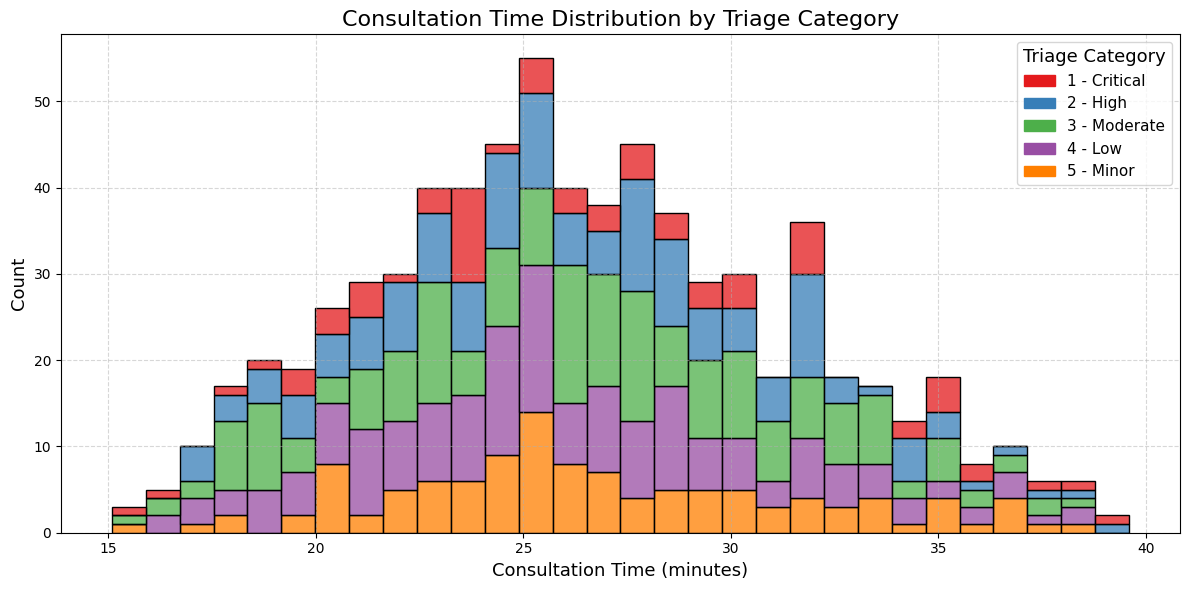

In [1305]:
import matplotlib.patches as mpatches

palette = sns.color_palette("Set1", n_colors=5)


plot_data = ed_patient_data[['triage_category', 'consultation_time_min']].copy()
plot_data['triage_category'] = plot_data['triage_category'].astype('category')


plt.figure(figsize=(12, 6))
hist = sns.histplot(
    data=plot_data,
    x='consultation_time_min',
    hue='triage_category',
    multiple='stack',
    palette=palette,
    bins=30,
    edgecolor='black',
    alpha=0.75
)

plt.title('Consultation Time Distribution by Triage Category', fontsize=16)
plt.xlabel('Consultation Time (minutes)', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

triage_labels = ['1 - Critical', '2 - High', '3 - Moderate', '4 - Low', '5 - Minor']
handles = [mpatches.Patch(color=palette[i], label=triage_labels[i]) for i in range(len(triage_labels))]

plt.legend(handles=handles, title='Triage Category', title_fontsize=13, fontsize=11, loc='upper right')

plt.show()

# KPIs collection and printing functions

## Collect and store KPIs across simulations

In [1306]:
class KPICollector:
    def __init__(self):
        self.waiting_times = []
        self.length_of_stay = []
        self.diverted_patients = 0
        self.doctor_busy_time = 0.0
        self.bed_busy_time = 0.0
        self.surgical_room_busy_time = 0.0
        self.diagnostic_room_busy_time = 0.0

    def reset(self):
        self.waiting_times.clear()
        self.length_of_stay.clear()
        self.diverted_patients = 0
        self.doctor_busy_time = 0.0
        self.bed_busy_time = 0.0
        self.surgical_room_busy_time = 0.0
        self.diagnostic_room_busy_time = 0.0

    def aggregate(self, other):
        self.waiting_times.extend(other.waiting_times)
        self.length_of_stay.extend(other.length_of_stay)
        self.diverted_patients += other.diverted_patients
        self.doctor_busy_time += other.doctor_busy_time
        self.bed_busy_time += other.bed_busy_time
        self.surgical_room_busy_time += other.surgical_room_busy_time
        self.diagnostic_room_busy_time += other.diagnostic_room_busy_time


### Kpi Collection function

In [1307]:
def kpi_statistics(data):
    if len(data) == 0:
        return {'mean': None, 'median': None, 'mode': None, 'std_dev': None}
    mode_val = stats.mode(data, keepdims=False).mode
    return {
        'mean': np.mean(data),
        'median': np.median(data),
        'mode': mode_val,
        'std_dev': np.std(data, ddof=1)
    }

In [1308]:
def utilization_stats(label, busy_time, capacity, sim_hours):
    utilization_pct = (busy_time / (capacity * sim_hours)) * 100
    print(f"{label}: {utilization_pct:.2f}% average utilization")

## Printing KPIs

In [1309]:
def print_resource_utilization(replication_results, scenario_name):
    num_replications = len(replication_results)

    total_doctor_busy = sum(res.doctor_busy_time for res in replication_results)
    total_bed_busy = sum(res.bed_busy_time for res in replication_results)
    total_surgical_busy = sum(res.surgical_room_busy_time for res in replication_results)
    total_diagnostic_busy = sum(res.diagnostic_room_busy_time for res in replication_results)

    print(f"\n{scenario_name} Resource Utilizations:")
    utilization_stats("Doctor Utilization", total_doctor_busy, DOCTOR_CAPACITY, SIM_TIME_HOURS * num_replications)
    utilization_stats("Bed Utilization", total_bed_busy, BED_CAPACITY, SIM_TIME_HOURS * num_replications)
    utilization_stats("Surgical Room Utilization", total_surgical_busy, SURGICAL_ROOM_CAPACITY, SIM_TIME_HOURS * num_replications)
    utilization_stats("Diagnostic Room Utilization", total_diagnostic_busy, DIAGNOSTIC_ROOM_CAPASITY, SIM_TIME_HOURS * num_replications)

In [1310]:
def print_kpi_stats(label, stats):
    print(f"{label}:")
    print(f"  Mean   : {float(stats['mean']):.2f} hours")
    print(f"  Median : {float(stats['median']):.2f} hours")
    print(f"  Mode   : {float(stats['mode']):.2f} hours")
    print(f"  Std Dev: {float(stats['std_dev']):.2f} hours\n")


# Control scenario simulation (Scenario 0, Baseline)

In [1311]:
DOCTOR_CAPACITY = 5
BED_CAPACITY = 15
SURGICAL_ROOM_CAPACITY = 2
DIAGNOSTIC_ROOM_CAPASITY = 10

In [1312]:
SIM_TIME_HOURS = 24 # two days simulation

# Patient process (for scenario 0 and 2)

journey of one patient within ED. Max steps are:


1. triage identification
2. registration *time resource
3. consultation *doctor, time resource
4. diagnostics *, doctor, capacity of diagnostical rooms/equipment, time resource
5. admission decision n possible treatment incl. surgery *bed + surgical room + doctor, time capacity



In [1313]:
def patient_process(env, patient_id, patient_data, doctors, beds, diagnostic_rooms, surgical_rooms, kpi):
    arrival_time = patient_data.loc[patient_id, 'arrival_time_hr']
    yield env.timeout(max(0, arrival_time - env.now))  # wait for arrival

    start_time = env.now

    # Simulate triage time (higher priority for critical patients)
    yield env.timeout(patient_data.loc[patient_id, 'triage_time_min'] / 60)

    # Simulate registration time
    yield env.timeout(patient_data.loc[patient_id, 'registration_time_min'] / 60)

    # Consultation phase
    with doctors.request() as req:
        result = yield req | env.timeout(0)  # Non-blocking request to check availability
        if req not in result:  # If no doctor is available, patient is diverted
            kpi.diverted_patients += 1
            kpi.length_of_stay.append(env.now - start_time)  # Track the time until diversion
            return  # Patient is diverted, end the process
        wait_time = env.now - start_time
        kpi.waiting_times.append(wait_time)
        consult_duration = patient_data.loc[patient_id, 'consultation_time_min'] / 60
        kpi.doctor_busy_time += consult_duration
        yield env.timeout(consult_duration)

    # Diagnostic testing if needed
    if patient_data.loc[patient_id, 'requires_diagnostics'] == 1:
        with diagnostic_rooms.request() as req:
            yield req
            diag_duration = patient_data.loc[patient_id, 'diagnostic_time_min'] / 60
            kpi.diagnostic_room_busy_time += diag_duration
            yield env.timeout(diag_duration)

    # Admission decision (increase admission rate to 20-30% to simulate overcrowding)
    admitted = np.random.rand() < 0.25  # Adjusted to 25% for realistic overcrowding

    if admitted:
        with beds.request() as bed_req:
            # Check if a bed is available
            bed_result = yield bed_req  # Block until a bed is available
            if bed_result is None:  # If no bed is available, patient is diverted
                kpi.diverted_patients += 1
                kpi.length_of_stay.append(env.now - start_time)  # Track the time until diversion
                return  # Patient is diverted, end the process

            # If surgery is required, we assign a surgical room
            surgery_needed = np.random.rand() < 0.5  # 50% chance of needing surgery
            if surgery_needed:
                with surgical_rooms.request() as surg_req:
                    result = yield surg_req | env.timeout(0)  # Non-blocking request to check surgical room availability
                    if req not in result:  # If no surgical room is available, patient is diverted
                        kpi.diverted_patients += 1
                        kpi.length_of_stay.append(env.now - start_time)  # Track the time until diversion
                        return  # Patient is diverted, end the process
                    surgery_duration = patient_data.loc[patient_id, 'surgery_time_min'] / 60
                    kpi.surgical_room_busy_time += surgery_duration
                    yield env.timeout(surgery_duration)

            # Treatment duration after surgery or for non-surgical patients
            treatment_duration = patient_data.loc[patient_id, 'treatment_time_min'] / 60
            kpi.bed_busy_time += treatment_duration
            yield env.timeout(treatment_duration)

    else:
        # Patients not admitted (no bed assigned) will go through treatment directly
        yield env.timeout(patient_data.loc[patient_id, 'treatment_time_min'] / 60)

    kpi.length_of_stay.append(env.now - start_time)


**Changes** for initial dataframe to fit the patient process with ***surgery***

In [1314]:
num_patients = len(ed_patient_data)

ed_patient_data['surgery_time_min'] = 0.0

# 50% require surgery
surgery_mask = np.random.binomial(1, 0.5, num_patients).astype(bool)

#TriangularDistribution for surgery time: min=60, mode=120, max=180 minutes
surgery_times = np.random.triangular(left=60, mode=120, right=180, size=num_patients)

# Assign surgery times only for patients selected for surgery
ed_patient_data.loc[surgery_mask, 'surgery_time_min'] = surgery_times[surgery_mask]

# Simulation function (for scenario 0 and 2)

In [1315]:
def run_control_simulation(patient_data, run_time=SIM_TIME_HOURS):
    import simpy
    env = simpy.Environment()

    doctors = simpy.Resource(env, capacity=DOCTOR_CAPACITY)
    beds = simpy.Resource(env, capacity=BED_CAPACITY)
    surgical_rooms = simpy.Resource(env, capacity=SURGICAL_ROOM_CAPACITY)
    diagnostic_rooms = simpy.Resource(env, capacity=DIAGNOSTIC_ROOM_CAPASITY)

    kpi = KPICollector()

    for patient_id in patient_data.index:
        env.process(patient_process(env, patient_id, patient_data, doctors, beds, diagnostic_rooms, surgical_rooms, kpi))

    env.run(until=run_time)

    return kpi

Run simulation  10 times

In [1316]:
num_replications = 10
replication_results = []

for i in range(num_replications):
    kpi = run_control_simulation(ed_patient_data, run_time=SIM_TIME_HOURS)
    replication_results.append(kpi)

#Aggregate KPIs from all replications
all_waiting_times = []
all_length_of_stay = []
total_diverted = 0

for res in replication_results:
    all_waiting_times.extend(res.waiting_times)
    all_length_of_stay.extend(res.length_of_stay)
    total_diverted += res.diverted_patients

# KPI statistics  on control scenario

In [1317]:
# Calculate aggregated statistics
waiting_stats = kpi_statistics(all_waiting_times)
los_stats = kpi_statistics(all_length_of_stay)

In [1318]:
print_kpi_stats("Aggregated Waiting Time Statistics", waiting_stats)
print_kpi_stats("Aggregated Length of Stay Statistics", los_stats)
print(f"Aggregated Total Diverted Patients: {total_diverted}\n")

Aggregated Waiting Time Statistics:
  Mean   : 0.29 hours
  Median : 0.29 hours
  Mode   : 0.17 hours
  Std Dev: 0.04 hours

Aggregated Length of Stay Statistics:
  Mean   : 0.57 hours
  Median : 0.32 hours
  Mode   : 0.16 hours
  Std Dev: 0.44 hours

Aggregated Total Diverted Patients: 5259



In [1319]:
print_resource_utilization(replication_results, "Control Scenario")


Control Scenario Resource Utilizations:
Doctor Utilization: 88.50% average utilization
Bed Utilization: 0.00% average utilization
Surgical Room Utilization: 0.00% average utilization
Diagnostic Room Utilization: 15.31% average utilization


# Manipulated Scenario 1 - fast track for minor cases

In [1320]:
FAST_TRACK_DOCTOR_CAPACITY = 5

### patient process with a fast track

In [1321]:
def patient_process_fast_track(env, patient_id, patient_data, doctors, beds, diagnostic_rooms, surgical_rooms, fast_track_doctors, kpi):
    arrival = patient_data.loc[patient_id, 'arrival_time_hr']
    yield env.timeout(max(0, arrival - env.now))

    start_time = env.now

    # Triage and registration
    yield env.timeout(patient_data.loc[patient_id, 'triage_time_min'] / 60)
    yield env.timeout(patient_data.loc[patient_id, 'registration_time_min'] / 60)

    triage_cat = patient_data.loc[patient_id, 'triage_category']

    # Doctor pool selection
    if triage_cat in [4, 5]:
        doctor_resource = fast_track_doctors
    else:
        doctor_resource = doctors

    # Consultation
    with doctor_resource.request() as req:
        yield req
        wait_time = env.now - start_time
        kpi.waiting_times.append(wait_time)
        duration = patient_data.loc[patient_id, 'consultation_time_min'] / 60
        kpi.doctor_busy_time += duration
        yield env.timeout(duration)

    # Diagnostics if needed
    if patient_data.loc[patient_id, 'requires_diagnostics'] == 1:
        with diagnostic_rooms.request() as req:
            yield req
            duration = patient_data.loc[patient_id, 'diagnostic_time_min'] / 60
            kpi.diagnostic_room_busy_time += duration
            yield env.timeout(duration)

    # Admission decision (30%)
    admitted = np.random.rand() < 0.3
    if admitted:
        with beds.request() as req:
            result = yield req | env.timeout(0)  # Non-blocking bed request
            if req not in result:
                kpi.diverted_patients += 1
                kpi.length_of_stay.append(env.now - start_time)
                return

            # Surgery decision for admitted patients (50% chance)
            surgery_needed = np.random.rand() < 0.5
            if surgery_needed:
                with surgical_rooms.request() as surg_req:
                    yield surg_req
                    surgery_duration = patient_data.loc[patient_id, 'surgery_time_min'] / 60
                    kpi.surgical_room_busy_time += surgery_duration
                    yield env.timeout(surgery_duration)

            # Treatment after surgery or admitted non-surgical patients
            treatment_duration = patient_data.loc[patient_id, 'treatment_time_min'] / 60
            kpi.bed_busy_time += treatment_duration
            yield env.timeout(treatment_duration)
    else:
        # Treatment without admission (no bed/surgery)
        yield env.timeout(patient_data.loc[patient_id, 'treatment_time_min'] / 60)

    kpi.length_of_stay.append(env.now - start_time)


### fast track sim runner

In [1322]:
def run_fast_track_simulation(patient_data, run_time=SIM_TIME_HOURS):
    import simpy
    env = simpy.Environment()

    doctors = simpy.Resource(env, capacity=DOCTOR_CAPACITY)
    fast_track_doctors = simpy.Resource(env, capacity=FAST_TRACK_DOCTOR_CAPACITY)
    beds = simpy.Resource(env, capacity=BED_CAPACITY)
    surgical_rooms = simpy.Resource(env, capacity=SURGICAL_ROOM_CAPACITY)
    diagnostic_rooms = simpy.Resource(env, capacity=DIAGNOSTIC_ROOM_CAPASITY)

    kpi = KPICollector()

    for patient_id in patient_data.index:
        env.process(patient_process_fast_track(env, patient_id, patient_data, doctors, beds,
                                              diagnostic_rooms, surgical_rooms, fast_track_doctors, kpi))

    env.run(until=run_time)

    return kpi

In [1323]:
num_replications = 10
replication_results_ft = []

for i in range(num_replications):
    kpi = run_fast_track_simulation(ed_patient_data, run_time=SIM_TIME_HOURS)
    replication_results_ft.append(kpi)

# KPI stats on scen1

In [1324]:
all_waiting_times_ft = []
all_length_of_stay_ft = []
total_diverted_ft = 0

for res in replication_results_ft:
    all_waiting_times_ft.extend(res.waiting_times)
    all_length_of_stay_ft.extend(res.length_of_stay)
    total_diverted_ft += res.diverted_patients

In [1325]:

waiting_stats_ft = kpi_statistics(all_waiting_times_ft)
los_stats_ft = kpi_statistics(all_length_of_stay_ft)


In [1326]:
print_kpi_stats("Fast-Track Aggregated Waiting Time Statistics", waiting_stats_ft)
print_kpi_stats("Fast-Track Aggregated Length of Stay Statistics", los_stats_ft)
print(f"Fast-Track Aggregated Total Diverted Patients: {total_diverted_ft}\n")

Fast-Track Aggregated Waiting Time Statistics:
  Mean   : 3.32 hours
  Median : 2.14 hours
  Mode   : 0.21 hours
  Std Dev: 2.85 hours

Fast-Track Aggregated Length of Stay Statistics:
  Mean   : 4.44 hours
  Median : 3.18 hours
  Mode   : 0.76 hours
  Std Dev: 3.00 hours

Fast-Track Aggregated Total Diverted Patients: 484



In [1327]:
print_resource_utilization(replication_results, "Control Scenario")
print_resource_utilization(replication_results_ft, "Fast-Track Scenario")


Control Scenario Resource Utilizations:
Doctor Utilization: 88.50% average utilization
Bed Utilization: 0.00% average utilization
Surgical Room Utilization: 0.00% average utilization
Diagnostic Room Utilization: 15.31% average utilization

Fast-Track Scenario Resource Utilizations:
Doctor Utilization: 195.66% average utilization
Bed Utilization: 9.40% average utilization
Surgical Room Utilization: 98.00% average utilization
Diagnostic Room Utilization: 33.25% average utilization


# Manipulated scenario 2 - additional sugical room n diagnostical equipment

In [1328]:
SCEN2_SURGICAL_ROOM_CAPACITY = 5
SCEN2_DIAGNOSTIC_ROOM_CAPACITY = 15 #+5
SCEN2_DOCTOR_CAPACITY = 8  #+3

## Patient process is the same as baseline

## runner of simulation function new to accumulate data

In [1329]:
def run_scenario2_simulation(patient_data, run_time=SIM_TIME_HOURS):
    import simpy
    env = simpy.Environment()

    doctors = simpy.Resource(env, capacity=SCEN2_DOCTOR_CAPACITY)
    beds = simpy.Resource(env, capacity=BED_CAPACITY)  # no change to beds
    surgical_rooms = simpy.Resource(env, capacity=SCEN2_SURGICAL_ROOM_CAPACITY)
    diagnostic_rooms = simpy.Resource(env, capacity=SCEN2_DIAGNOSTIC_ROOM_CAPACITY)

    kpi = KPICollector()

    for patient_id in patient_data.index:
        env.process(patient_process(env, patient_id, patient_data, doctors, beds, diagnostic_rooms, surgical_rooms, kpi))

    env.run(until=run_time)

    return kpi


In [1330]:
num_replications = 10
replication_results_scen2 = []

for i in range(num_replications):
    kpi = run_scenario2_simulation(ed_patient_data, run_time=SIM_TIME_HOURS)
    replication_results_scen2.append(kpi)

# Scen2 KPIs

In [1331]:
all_waiting_times_s2 = []
all_length_of_stay_s2 = []
total_diverted_s2 = 0

for res in replication_results_scen2:
    all_waiting_times_s2.extend(res.waiting_times)
    all_length_of_stay_s2.extend(res.length_of_stay)
    total_diverted_s2 += res.diverted_patients

In [1332]:
waiting_stats_s2 = kpi_statistics(all_waiting_times_s2)
los_stats_s2 = kpi_statistics(all_length_of_stay_s2)

In [1333]:

print_kpi_stats("Scenario 2 Aggregated Waiting Time Statistics", waiting_stats_s2)
print_kpi_stats("Scenario 2 Aggregated Length of Stay Statistics", los_stats_s2)
print(f"Scenario 2 Aggregated Total Diverted Patients: {total_diverted_s2}\n")

Scenario 2 Aggregated Waiting Time Statistics:
  Mean   : 0.29 hours
  Median : 0.29 hours
  Mode   : 0.17 hours
  Std Dev: 0.04 hours

Scenario 2 Aggregated Length of Stay Statistics:
  Mean   : 0.74 hours
  Median : 0.66 hours
  Mode   : 0.16 hours
  Std Dev: 0.49 hours

Scenario 2 Aggregated Total Diverted Patients: 4203



In [1334]:
print_resource_utilization(replication_results_scen2, "Scenario 2")


Scenario 2 Resource Utilizations:
Doctor Utilization: 138.71% average utilization
Bed Utilization: 0.00% average utilization
Surgical Room Utilization: 0.00% average utilization
Diagnostic Room Utilization: 24.71% average utilization


In [1335]:
print_resource_utilization(replication_results, "Control Scenario")
print_resource_utilization(replication_results_ft, "Fast-Track Scenario")


Control Scenario Resource Utilizations:
Doctor Utilization: 88.50% average utilization
Bed Utilization: 0.00% average utilization
Surgical Room Utilization: 0.00% average utilization
Diagnostic Room Utilization: 15.31% average utilization

Fast-Track Scenario Resource Utilizations:
Doctor Utilization: 195.66% average utilization
Bed Utilization: 9.40% average utilization
Surgical Room Utilization: 98.00% average utilization
Diagnostic Room Utilization: 33.25% average utilization


# Manipulated Scenario 3 - mixed

parameters are set again (not to forget, plus can do them const above)

In [1336]:
SCEN2_SURGICAL_ROOM_CAPACITY = 5 #+10
SCEN2_DIAGNOSTIC_ROOM_CAPACITY = 15 #+5
SCEN2_DOCTOR_CAPACITY = 8  #+3
FAST_TRACK_DOCTOR_CAPACITY = 5     #from scen1, fast track doctors

## run s2

In [1337]:
def run_scenario3_simulation(patient_data, run_time=SIM_TIME_HOURS):
    env = simpy.Environment()

    doctors = simpy.Resource(env, capacity=SCEN2_DOCTOR_CAPACITY)
    fast_track_doctors = simpy.Resource(env, capacity=FAST_TRACK_DOCTOR_CAPACITY)
    beds = simpy.Resource(env, capacity=BED_CAPACITY)
    surgical_rooms = simpy.Resource(env, capacity=SCEN2_SURGICAL_ROOM_CAPACITY)
    diagnostic_rooms = simpy.Resource(env, capacity=SCEN2_DIAGNOSTIC_ROOM_CAPACITY)

    kpi = KPICollector()

    for patient_id in patient_data.index:
        env.process(patient_process_fast_track(env, patient_id, patient_data,
                                              doctors, beds, diagnostic_rooms,
                                              surgical_rooms, fast_track_doctors, kpi))

    env.run(until=run_time)

    return kpi


In [1338]:

num_replications = 10
replication_results_s3 = []

for i in range(num_replications):
    kpi = run_scenario3_simulation(ed_patient_data, run_time=SIM_TIME_HOURS)
    replication_results_s3.append(kpi)


In [1339]:

all_waiting_times_s3 = []
all_length_of_stay_s3 = []
total_diverted_s3 = 0

In [1340]:
for res in replication_results_s3:
    all_waiting_times_s3.extend(res.waiting_times)
    all_length_of_stay_s3.extend(res.length_of_stay)
    total_diverted_s3 += res.diverted_patients

# KPIs scen3 mixed

In [1341]:
waiting_stats_s3 = kpi_statistics(all_waiting_times_s3)
los_stats_s3 = kpi_statistics(all_length_of_stay_s3)


In [1342]:
print_kpi_stats("Scenario 3 Aggregated Waiting Time Statistics", waiting_stats_s3)
print_kpi_stats("Scenario 3 Aggregated Length of Stay Statistics", los_stats_s3)
print(f"Scenario 3 Aggregated Total Diverted Patients: {total_diverted_s3}\n")

Scenario 3 Aggregated Waiting Time Statistics:
  Mean   : 1.01 hours
  Median : 0.94 hours
  Mode   : 0.17 hours
  Std Dev: 0.62 hours

Scenario 3 Aggregated Length of Stay Statistics:
  Mean   : 2.10 hours
  Median : 1.89 hours
  Mode   : 0.76 hours
  Std Dev: 0.90 hours

Scenario 3 Aggregated Total Diverted Patients: 62



In [1343]:

print_resource_utilization(replication_results_s3, "Scenario 3")



Scenario 3 Resource Utilizations:
Doctor Utilization: 245.12% average utilization
Bed Utilization: 17.62% average utilization
Surgical Room Utilization: 189.94% average utilization
Diagnostic Room Utilization: 41.21% average utilization


In [1344]:
print_resource_utilization(replication_results, "Control Scenario")
print_resource_utilization(replication_results_ft, "Fast-Track Scenario")
print_resource_utilization(replication_results_scen2, "Scenario 2")


Control Scenario Resource Utilizations:
Doctor Utilization: 88.50% average utilization
Bed Utilization: 0.00% average utilization
Surgical Room Utilization: 0.00% average utilization
Diagnostic Room Utilization: 15.31% average utilization

Fast-Track Scenario Resource Utilizations:
Doctor Utilization: 195.66% average utilization
Bed Utilization: 9.40% average utilization
Surgical Room Utilization: 98.00% average utilization
Diagnostic Room Utilization: 33.25% average utilization

Scenario 2 Resource Utilizations:
Doctor Utilization: 138.71% average utilization
Bed Utilization: 0.00% average utilization
Surgical Room Utilization: 0.00% average utilization
Diagnostic Room Utilization: 24.71% average utilization


# ----------------------------------------

# KPIs summary

In [1345]:
def aggregate_kpis(replication_results, scenario_name):
    all_waiting = []
    all_los = []
    total_diverted = 0

    for idx, kpi in enumerate(replication_results):
        if len(kpi.waiting_times) != len(kpi.length_of_stay):
            raise ValueError(f"Replication {idx} has mismatched lengths: waiting_times={len(kpi.waiting_times)} vs length_of_stay={len(kpi.length_of_stay)}")
        all_waiting.extend(kpi.waiting_times)
        all_los.extend(kpi.length_of_stay)
        total_diverted += kpi.diverted_patients

    n = len(all_waiting)
    return pd.DataFrame({
        'Scenario': [scenario_name] * n,
        'Waiting_Time': all_waiting,
        'Length_of_Stay': all_los,
        'Diverted_Patients': [total_diverted] * n
    })


# Stats summary

In [1346]:
# Aggregation function — unchanged but complete here for reference
def aggregate_kpis(replication_results, scenario_name):
    data = []
    for res in replication_results:
        for wt in res.waiting_times:
            data.append({'Scenario': scenario_name, 'KPI': 'Waiting Time', 'Value': wt})
        for los in res.length_of_stay:
            data.append({'Scenario': scenario_name, 'KPI': 'Length of Stay', 'Value': los})
        data.append({'Scenario': scenario_name, 'KPI': 'Diverted Patients', 'Value': res.diverted_patients})
        data.append({'Scenario': scenario_name, 'KPI': 'Doctor Busy Time', 'Value': res.doctor_busy_time})
        data.append({'Scenario': scenario_name, 'KPI': 'Bed Busy Time', 'Value': res.bed_busy_time})
        data.append({'Scenario': scenario_name, 'KPI': 'Surgical Room Busy Time', 'Value': res.surgical_room_busy_time})
        data.append({'Scenario': scenario_name, 'KPI': 'Diagnostic Room Busy Time', 'Value': res.diagnostic_room_busy_time})
    return pd.DataFrame(data)

# Aggregate data for all scenarios
df_control = aggregate_kpis(replication_results, 'Control')
df_ft = aggregate_kpis(replication_results_ft, 'Fast-Track')
df_s2 = aggregate_kpis(replication_results_scen2, 'More Rooms for Surgery and Diagnostics')
df_s3 = aggregate_kpis(replication_results_s3, 'Combined')

# Combine all
df_all = pd.concat([df_control, df_ft, df_s2, df_s3], ignore_index=True)

# Summary stats function - clean and readable
def kpi_grouped_summary_clean(df):
    summary_records = []
    for scenario in sorted(df['Scenario'].unique()):
        for kpi_name in sorted(df['KPI'].unique()):
            values = df.loc[(df['Scenario'] == scenario) & (df['KPI'] == kpi_name), 'Value']
            n = len(values)
            if n == 0:
                continue

            mean = values.mean()
            median = values.median()
            try:
                mode_val = stats.mode(values, keepdims=False).mode
            except Exception:
                mode_val = np.nan
            std_dev = values.std(ddof=1)
            if n > 1:
                ci_low, ci_high = stats.t.interval(0.95, n-1, loc=mean, scale=stats.sem(values))
            else:
                ci_low, ci_high = (np.nan, np.nan)

            summary_records.append({
                'Scenario': scenario,
                'KPI': kpi_name,
                'Count': n,
                'Mean': round(mean, 3),
                'Median': round(median, 3),
                'Mode': round(mode_val, 3) if not pd.isna(mode_val) else None,
                'Std Dev': round(std_dev, 3),
                '95% CI Lower': round(ci_low, 3) if not pd.isna(ci_low) else None,
                '95% CI Upper': round(ci_high, 3) if not pd.isna(ci_high) else None,
            })
    return pd.DataFrame(summary_records)

# Generate summary
summary_df = kpi_grouped_summary_clean(df_all)

# Print summaries per scenario clearly
for scenario in summary_df['Scenario'].unique():
    print(f"\n--- KPI Summary for Scenario: {scenario} ---")
    display(summary_df[summary_df['Scenario'] == scenario].drop(columns='Scenario').reset_index(drop=True))

/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc



--- KPI Summary for Scenario: Combined ---


,KPI,Count,Mean,Median,Mode,Std Dev,95% CI Lower,95% CI Upper
0,Bed Busy Time,10,63.432,62.937,59.103,3.392,61.006,65.859
1,Diagnostic Room Busy Time,10,98.896,98.896,98.896,0.000,98.896,98.896
2,Diverted Patients,10,6.200,7.500,8.000,3.645,3.592,8.808
3,Doctor Busy Time,10,294.143,294.143,294.143,0.000,NaN,NaN
4,Length of Stay,6324,2.103,1.887,0.761,0.904,2.080,2.125
5,Surgical Room Busy Time,10,91.171,91.331,67.396,9.539,84.347,97.994
6,Waiting Time,6680,1.015,0.937,0.166,0.622,1.000,1.030



--- KPI Summary for Scenario: Control ---


,KPI,Count,Mean,Median,Mode,Std Dev,95% CI Lower,95% CI Upper
0,Bed Busy Time,10,0.000,0.000,0.000,0.000,NaN,NaN
1,Diagnostic Room Busy Time,10,36.755,36.755,36.755,0.000,NaN,NaN
2,Diverted Patients,10,525.900,527.000,521.000,5.877,521.696,530.104
3,Doctor Busy Time,10,106.198,106.198,106.198,0.000,106.198,106.198
4,Length of Stay,7017,0.571,0.319,0.162,0.438,0.561,0.582
5,Surgical Room Busy Time,10,0.000,0.000,0.000,0.000,NaN,NaN
6,Waiting Time,2430,0.288,0.292,0.166,0.043,0.287,0.290



--- KPI Summary for Scenario: Fast-Track ---


,KPI,Count,Mean,Median,Mode,Std Dev,95% CI Lower,95% CI Upper
0,Bed Busy Time,10,33.837,33.677,29.042,4.135,30.879,36.795
1,Diagnostic Room Busy Time,10,79.811,79.811,79.811,0.000,NaN,NaN
2,Diverted Patients,10,48.400,52.000,22.000,13.057,39.059,57.741
3,Doctor Busy Time,10,234.788,234.788,234.788,0.000,234.788,234.788
4,Length of Stay,4976,4.443,3.177,0.761,2.998,4.359,4.526
5,Surgical Room Busy Time,10,47.041,47.022,45.740,1.088,46.263,47.820
6,Waiting Time,5310,3.323,2.145,0.214,2.847,3.246,3.399



--- KPI Summary for Scenario: More Rooms for Surgery and Diagnostics ---


,KPI,Count,Mean,Median,Mode,Std Dev,95% CI Lower,95% CI Upper
0,Bed Busy Time,10,0.000,0.000,0.000,0.000,NaN,NaN
1,Diagnostic Room Busy Time,10,59.316,59.316,59.316,0.000,59.316,59.316
2,Diverted Patients,10,420.300,419.500,416.000,5.677,416.239,424.361
3,Doctor Busy Time,10,166.451,166.451,166.451,0.000,NaN,NaN
4,Length of Stay,6965,0.739,0.659,0.162,0.487,0.727,0.750
5,Surgical Room Busy Time,10,0.000,0.000,0.000,0.000,NaN,NaN
6,Waiting Time,3760,0.290,0.289,0.166,0.044,0.288,0.291


# Visualisation and comparison  of the scenarios (and versus control)

## Boxplot - distribution of waiting time by scenario

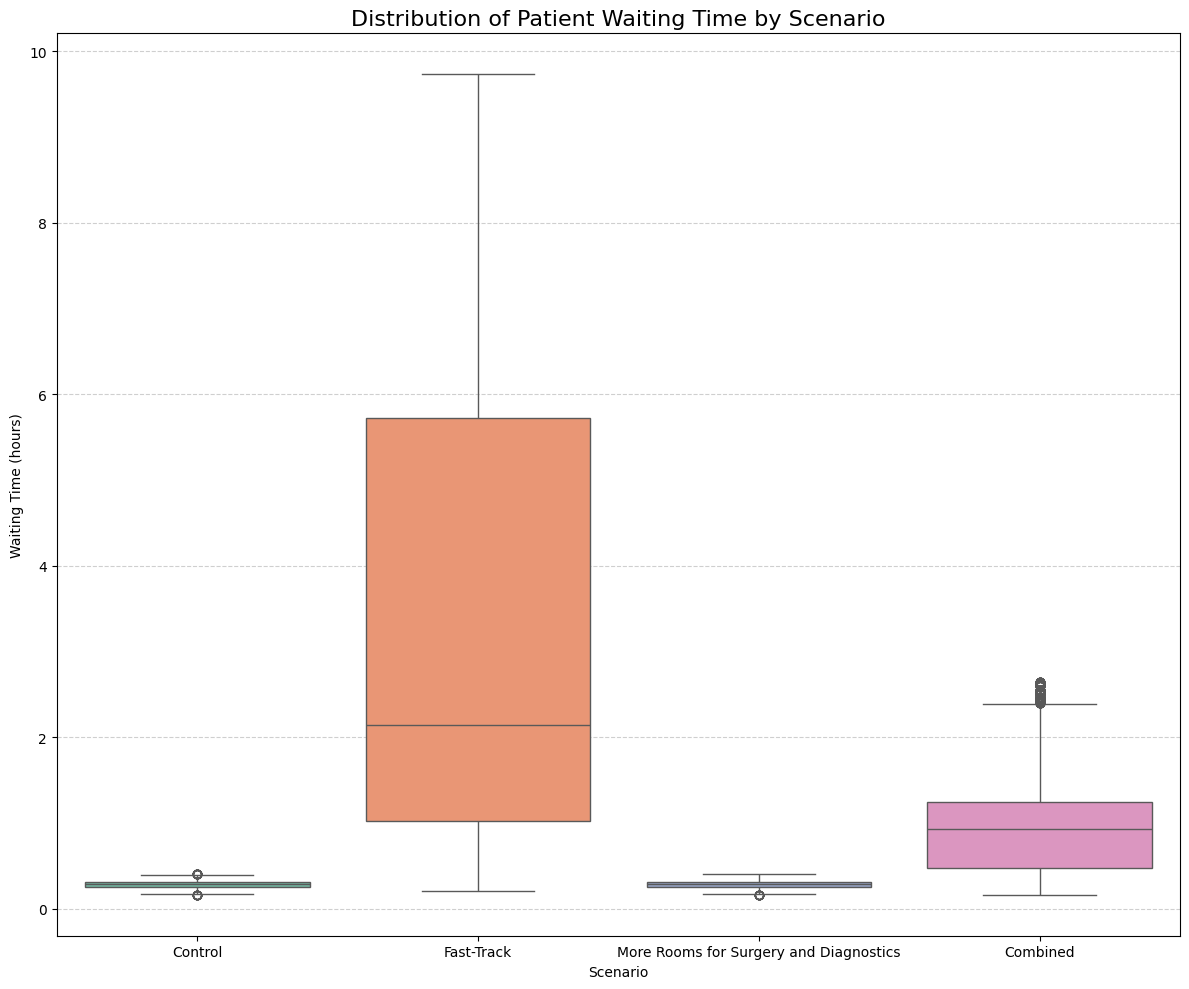

In [1347]:
plt.figure(figsize=(12,10))
sns.boxplot(
    data=df_all[df_all['KPI'] == 'Waiting Time'],
    x='Scenario', y='Value',
    hue='Scenario',
    palette='Set2',
    legend=False
)
plt.title('Distribution of Patient Waiting Time by Scenario', fontsize=16)
plt.ylabel('Waiting Time (hours)')
plt.xlabel('Scenario')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Violin distr. for LOS

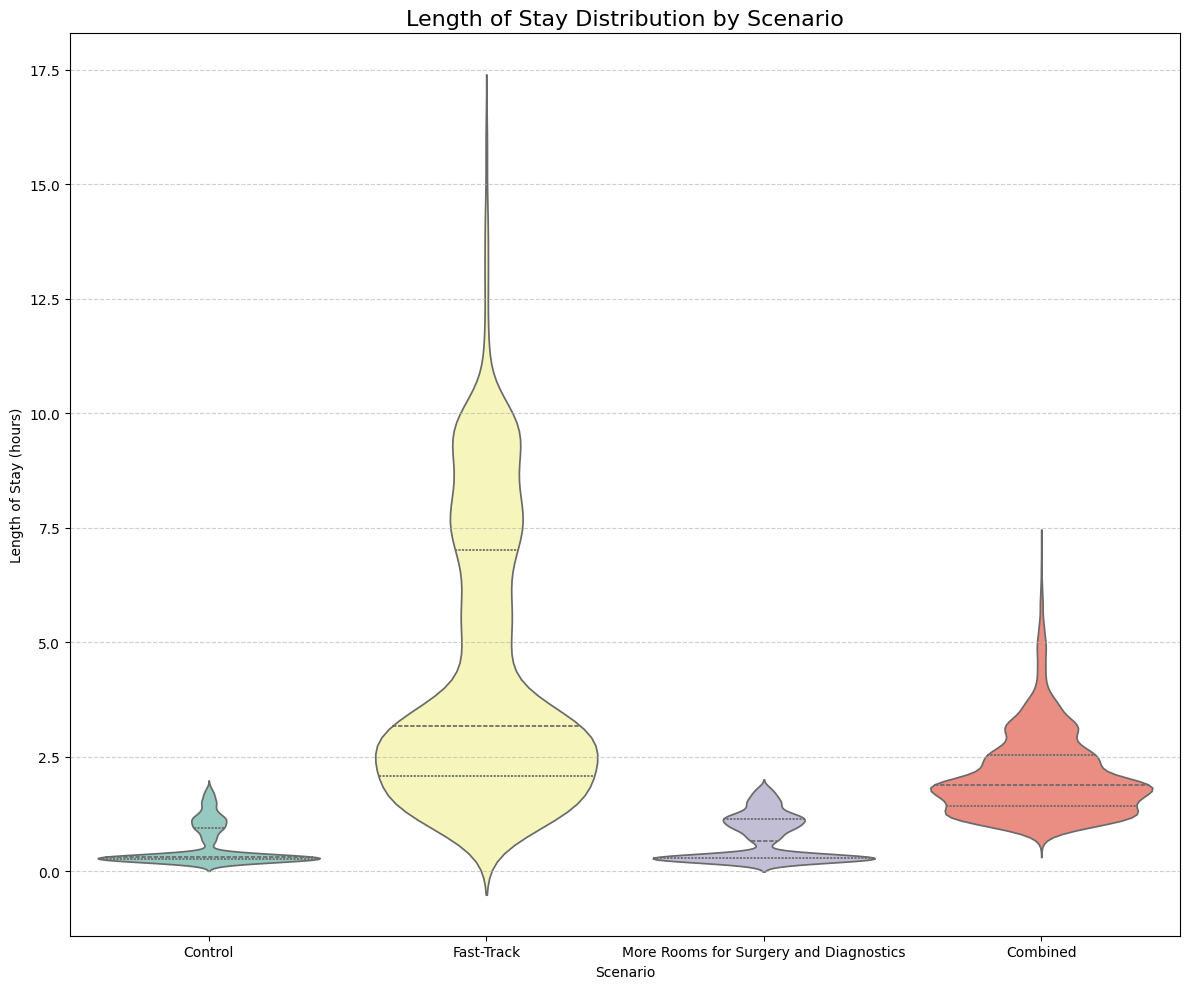

In [1348]:
plt.figure(figsize=(12,10))
sns.violinplot(
    data=df_all[df_all['KPI'] == 'Length of Stay'],
    x='Scenario', y='Value',
    hue='Scenario',
    legend=False,
    palette='Set3',
    inner='quartile'
)
plt.title('Length of Stay Distribution by Scenario', fontsize=16)
plt.ylabel('Length of Stay (hours)')
plt.xlabel('Scenario')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Bar plot - mean LPIs with 95% confidence intervals

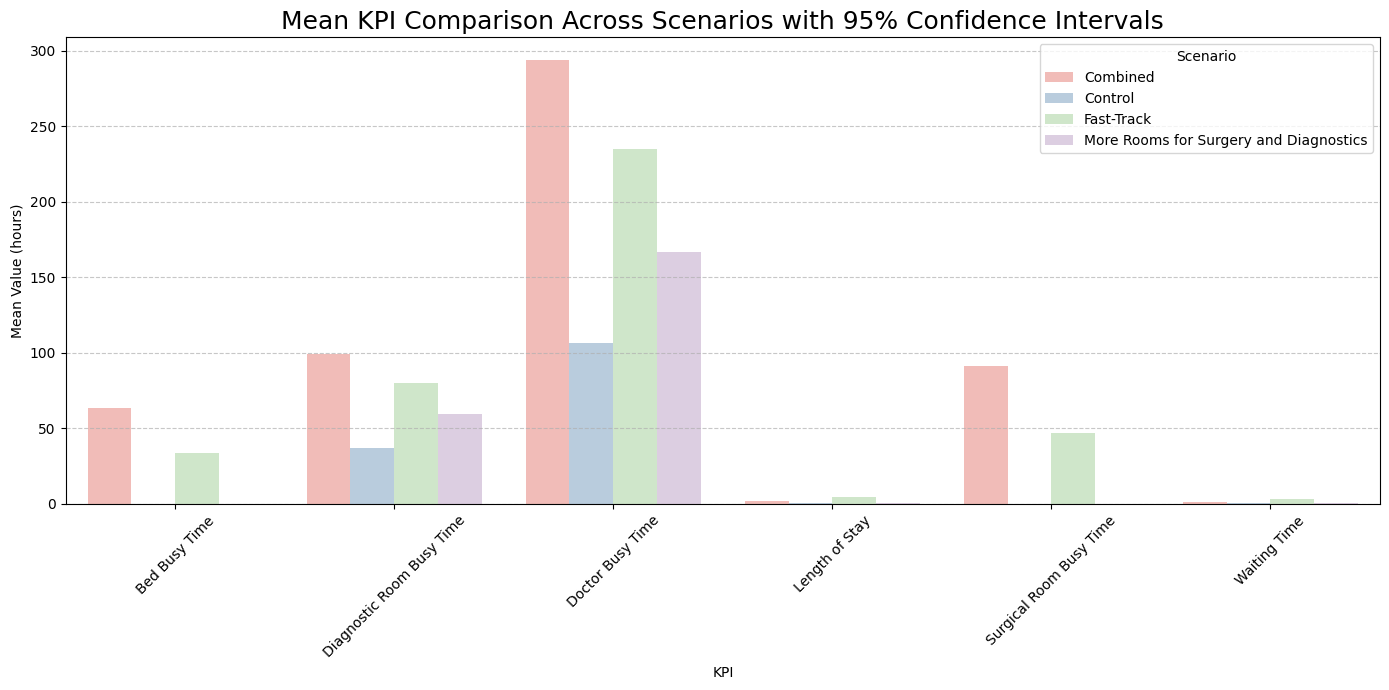

In [1349]:
mean_kpis = summary_df[~summary_df['KPI'].isin(['Diverted Patients'])]

plt.figure(figsize=(14,7))
sns.barplot(
    data=mean_kpis, x='KPI', y='Mean', hue='Scenario',
    palette='Pastel1', capsize=0.1,
    err_kws={'color': 'gray'}
)
plt.title('Mean KPI Comparison Across Scenarios with 95% Confidence Intervals', fontsize=18)
plt.ylabel('Mean Value (hours)')
plt.xlabel('KPI')
plt.legend(title='Scenario', loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Resource Utilization Comparison — Stacked Bar Chart

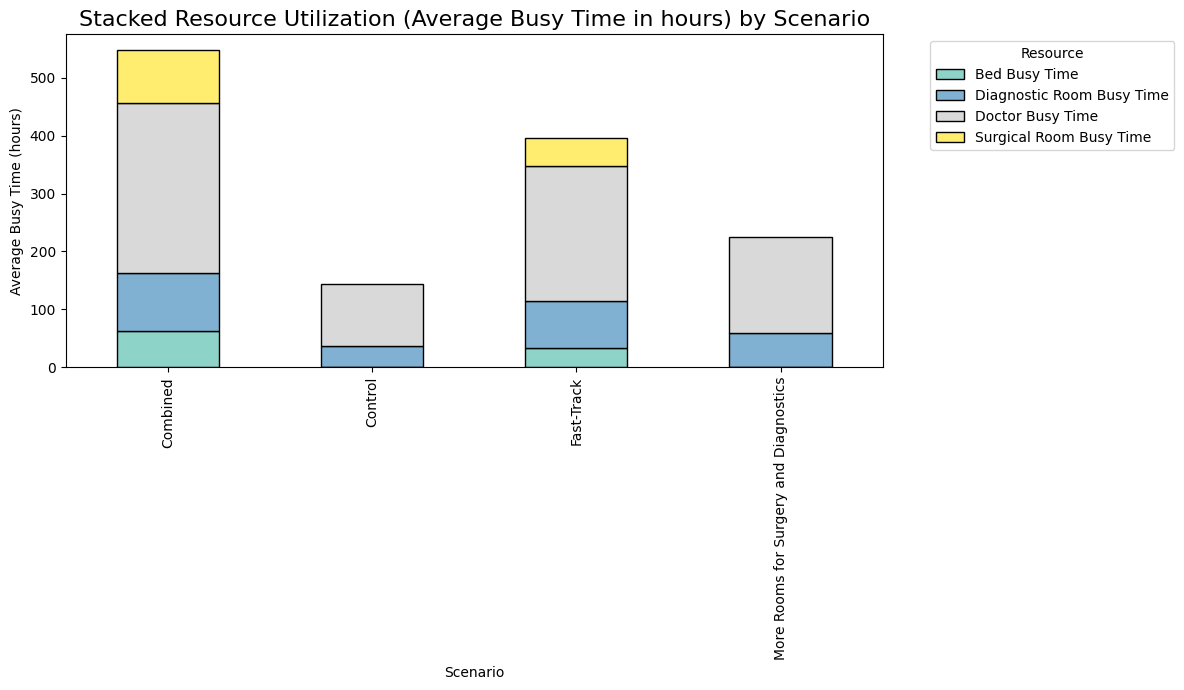

In [1350]:
resource_kpis = summary_df[summary_df['KPI'].str.contains('Busy Time')]

# Pivot to wide format for stacked bar
resource_pivot = resource_kpis.pivot(index='Scenario', columns='KPI', values='Mean')

resource_pivot.plot(
    kind='bar', stacked=True, figsize=(12,7),
    colormap='Set3', edgecolor='black'
)
plt.title('Stacked Resource Utilization (Average Busy Time in hours) by Scenario', fontsize=16)
plt.ylabel('Average Busy Time (hours)')
plt.xlabel('Scenario')
plt.legend(title='Resource', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Bar plot - diverted patients

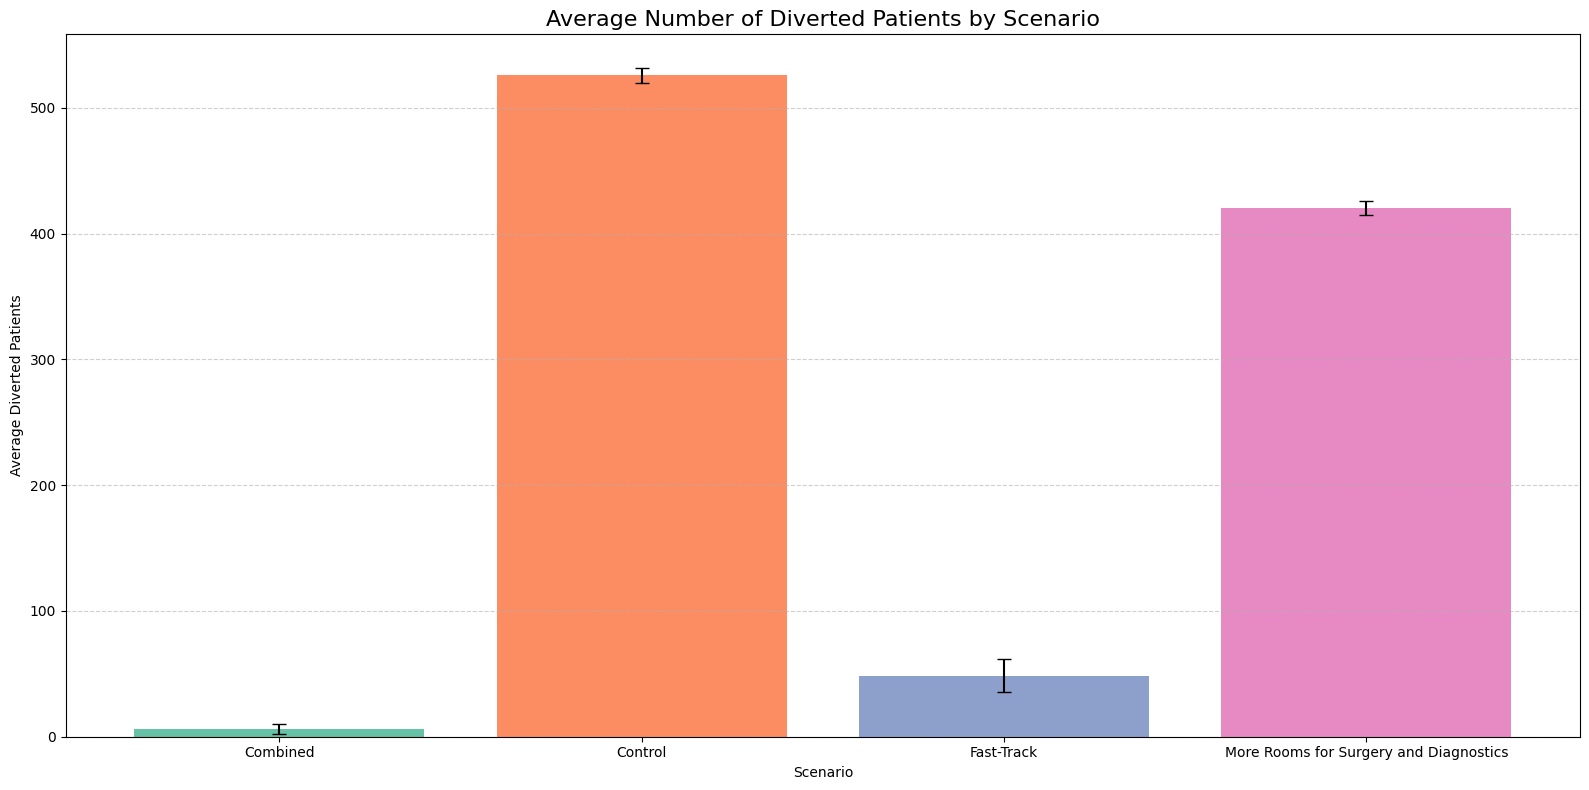

In [1351]:
diverted = summary_df[summary_df['KPI'] == 'Diverted Patients']

# Extract means and std devs by scenario for diverted patients
means = diverted['Mean'].values
std_devs = diverted['Std Dev'].fillna(0).values
scenarios = diverted['Scenario'].values

plt.figure(figsize=(16,8))
plt.bar(scenarios, means, yerr=std_devs, capsize=5, color=sns.color_palette('Set2', len(scenarios)))
plt.title('Average Number of Diverted Patients by Scenario', fontsize=16)
plt.ylabel('Average Diverted Patients')
plt.xlabel('Scenario')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()